In [1197]:
from units import *
import matplotlib.pyplot as plt
from astrometry_sim import QuasarSim

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1198]:
# sim = QuasarSim(n_sh = 50, sh_m_frac=1e-4, max_sep=2, m_delta=1e7*M_s, verbose=True, save=False, save_tag='log10M_11_mfrac_0.5_mc_0',sh_distrib='MW')
sim = QuasarSim(n_calib=100, verbose=True, sh_distrib='Aq1', m_min=1e-5)

In [1199]:
# sim.update_sample(sh_m_frac=1, m_delta=1e6*M_s, c200_delta=100000.)

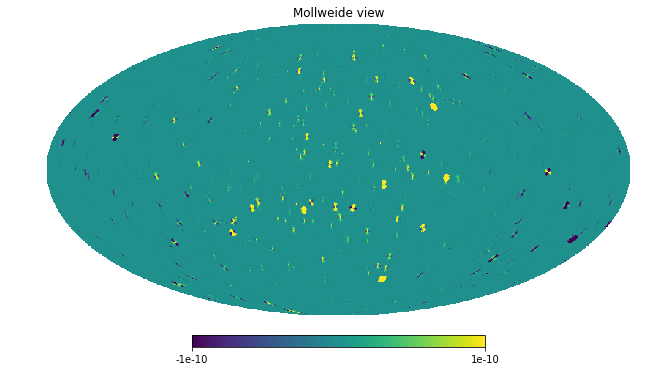

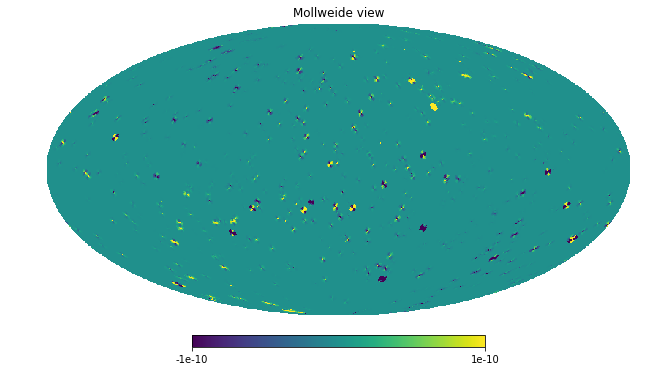

In [1218]:
import healpy as hp
maxx = 10**-10
hp.mollview(sim.mu_qsrs[:,0],max=maxx, min=-maxx)
hp.mollview(sim.mu_qsrs[:,1],max=maxx, min=-maxx)
# hp.mollview(np.log10(sim.mu_qsrs[:,0]),max=maxx,min=-12)
# hp.mollview(np.log10(sim.mu_qsrs[:,1]),max=maxx,min=-12)


In [1193]:
# plt.figure(figsize=(6,4), dpi=100, facecolor='w', edgecolor='k')
# lims = 2e-3
# bins = np.linspace(-lims,lims,100)
# plt.hist(sim.mu_qsrs[:,0]/1e-3,bins = bins, histtype='step', label='$\Delta\dot\\theta_l$');
# plt.hist(sim.mu_qsrs[:,1]/1e-3,bins = bins, histtype='step', label='$\Delta\dot\\theta_b$');
# plt.xlabel("$\Delta\dot\\theta$ [mas/yr]")
# plt.ylabel("N$_\\mathrm{quasars}$")
# plt.title('Induced quasar velocities, CDM sim')
# plt.yscale("log")
# plt.legend()

In [1180]:
from healpy.sphtfunc import Alm
from tqdm import *

def fB(l, m, gtheta_ary, gphi_ary, lmax):
    return 1/np.sqrt(l*(l+1))*(((l*(l-m+1)/(2*l+1))*gtheta_ary[Alm.getidx(lmax, l+1,m)]) - ((l+1)*(l+m)/(2*l+1)*gtheta_ary[Alm.getidx(lmax, l-1,m)] -1.j*m*gphi_ary[Alm.getidx(lmax, l,m)]))
    
def fC(l, m, gtheta_ary, gphi_ary, lmax):
    return 1/np.sqrt(l*(l+1))*(-1.j*m*gtheta_ary[Alm.getidx(lmax, l,m)]-(l*(l-m+1)/(2*l+1))*gphi_ary[Alm.getidx(lmax, l+1,m)] + ((l+1)*(l+m)/(2*l+1)*gphi_ary[Alm.getidx(lmax, l-1,m)]))

In [1181]:
def get_alm_2d(map_theta, map_phi):
    nside = hp.npix2nside(len(map_theta))
    lmax = 3*nside - 1

    alm_theta = hp.map2alm(map_theta, lmax=lmax)
    alm_phi = hp.map2alm(map_phi, lmax=lmax)
    return alm_theta, alm_phi, lmax

In [1182]:
def get_Cells(alm_theta, alm_phi, lmax):
    fB_ary = np.zeros((lmax, lmax))
    fC_ary = np.zeros((lmax, lmax))
    for l in tqdm(range(lmax - 1)):
        for m in range(l):
            fB_ary[l][m] = np.abs(fB(l, m , alm_theta, alm_phi, lmax))**2
            fC_ary[l][m] = np.abs(fC(l, m , alm_theta, alm_phi, lmax))**2

    Cl_B = 2*np.sum(fB_ary, axis=1)
    Cl_C = 2*np.sum(fC_ary, axis=1)

    ell = np.arange(len(Cl_B))

#     Cl_B /= 2*ell+1
#     Cl_C /= 2*ell+1
    return Cl_B, Cl_C

def bin_cells(cells, lmin, lmax, nbins):
    bin_edges = np.round(np.logspace(np.log10(lmin),np.log10(lmax), nbins + 1))
    cells_binned = [np.mean(cells[np.int(bin_edges[i]):np.int(bin_edges[i+1])]) for i in range(nbins)]
    ells_binned = (bin_edges[1:] + bin_edges[:-1])/2.
    return ells_binned, cells_binned

In [1200]:
nside = 128
theta, phi = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
l_map = sim.mu_qsrs[:,0]/np.sin(theta)
b_map = sim.mu_qsrs[:,1]/np.sin(theta)

In [1201]:
alm_theta, alm_phi, lmax = get_alm_2d(b_map, l_map)

In [1202]:
Cl_B, Cl_C = get_Cells(alm_theta, alm_phi, lmax)

100%|██████████| 382/382 [00:02<00:00, 165.38it/s]


In [1203]:
# ell = np.arange(len(Cl_B))
# lmin = 5
# nlbins = 20

# plt.plot(bin_cells(Cl_B, lmin, lmax, nlbins)[0], bin_cells(Cl_B, lmin, lmax, nlbins)[1], label="Curl-free, Data", color='cornflowerblue', alpha=0.9)
# plt.plot(bin_cells(Cl_C, lmin, lmax, nlbins)[0], bin_cells(Cl_C, lmin, lmax, nlbins)[1], label="Div-free, Data", color='firebrick', alpha=0.9)
# plt.legend()

In [1204]:
Cl_tot = hp.anafast(np.sqrt(sim.mu_qsrs[:,0]**2 + sim.mu_qsrs[:,1]**2))

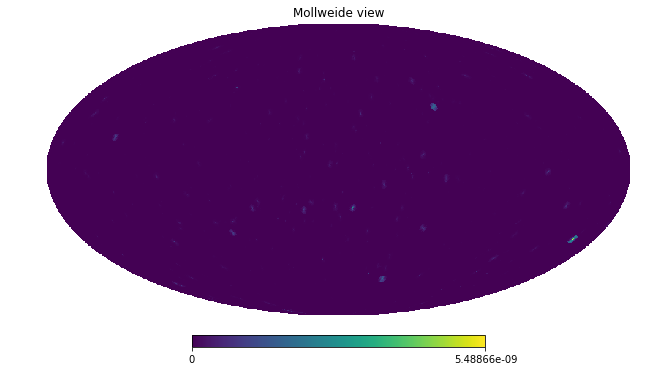

In [1205]:
hp.mollview(np.sqrt(sim.mu_qsrs[:,0]**2 + sim.mu_qsrs[:,1]**2))

(2, 383)

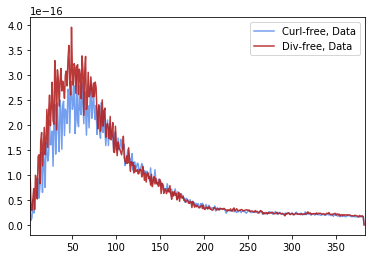

In [1207]:
ell = np.arange(len(Cl_B))

plt.plot(ell, 1e6*Cl_B, label="Curl-free, Data", color='cornflowerblue', alpha=0.9)
plt.plot(ell, 1e6*Cl_C, label="Div-free, Data", color='firebrick', alpha=0.9)
# plt.plot(ell, Cl_tot[1:]*ell*(ell+1), label="Tot", color='grey', alpha=0.9)

plt.legend()
plt.xlim(2, lmax)
# plt.ylim(0,4e-23)